# Subgroup B: Measuring Campaign ROI

## Exploratory Data Analysis

In this segment, data relevant to addressing the business question is loaded in and prepared for exploratory data analysis.

In [29]:
import  pandas as pd
import numpy as np
import os

# loading in relevant datasets
os.chdir("../Data DSA3101/")
print(os.getcwd())
campaigns = pd.read_csv("campaigns.csv")
customer_engagement = pd.read_csv("customer_engagement.csv")

print(campaigns.head())
print(customer_engagement.head())
print("\n")
print("===========================================================")
print("Information on campaigns dataset")
campaigns.info()
print("\n")
print("===========================================================")
print("Information on customer_engagement dataset")
customer_engagement.info()

C:\Users\rusya\DSA3101-Project\Data DSA3101
   campaign_id     customer_segment  \
0            1              Retired   
1            2        Middle-Market   
2            3              Retired   
3            4     Budget-Conscious   
4            5  Young Professionals   

                                    campaign_name             campaign_type  \
0          Wealth Management Campaign for Retired                     Email   
1            Auto Loan Campaign for Middle-Market  Mobile App Notifications   
2                   Mortgage Campaign for Retired                     Email   
3     Personal Loan Campaign for Budget-Conscious                     Email   
4  Personal Loan Campaign for Young Professionals  Mobile App Notifications   

   start_date    end_date  recommended_product_id recommended_product_name  \
0  2022-03-17  2022-05-04                     107        Wealth Management   
1  2022-03-23  2022-05-02                     106                Auto Loan   
2  2022-05-2

## Feature Engineering
We ensure that columns relevant to answering our business question are created before answering the subquestion in Section B: Measuring Campaign ROI.
In the following code block, the following features are generated: `conversion_rate`, `customer_lifetime_value` and `acquisition_cost`.
`ROI` of past marketing campaigns are also computed, serving as the response variable on which our model will be based on.

### Generating `conversion_rate`

`conversion_rate` is obtained by first determining the number of customers that a campaign has engaged with a customer (i.e number of rows for where `sent` == "Yes", for each campaign), to give us `total_engagements`. This is derived from the `customer_engagement` dataset.

The number of successful conversions is also derived from the `customer_engagement` dataset. `conversion_rate` for each campaign is then computed as follows:

$$
\text{conversion rate} = \frac{\text{successful conversions}}{\text{total engagements}}
$$

In [30]:
# calculating total engagements
total_engagements = customer_engagement[customer_engagement["sent"] == "Yes"].groupby("campaign_id").size().reset_index(name = "total_engagements")
print(total_engagements.head())

# calculating number of successful conversions
successful_conversions = customer_engagement[customer_engagement["conversion_status"] == "Yes"] \
    .groupby("campaign_id").size().reset_index(name="successful_conversions")
print(successful_conversions.head())

# merging engagement data
conversion_data = total_engagements.merge(successful_conversions, on="campaign_id", how="left")
print(conversion_data.head())

# in case no conversions happened for a campaign, fill NA as 0
conversion_data["successful_conversions"] = conversion_data["successful_conversions"].fillna(0)

# computing conversion rate
conversion_data["conversion_rate"] = conversion_data["successful_conversions"] / conversion_data["total_engagements"]
conversion_data.head()

   campaign_id  total_engagements
0            1                473
1            2                740
2            3                946
3            4                570
4            5                829
   campaign_id  successful_conversions
0            1                      52
1            2                      59
2            3                     113
3            4                      48
4            5                      66
   campaign_id  total_engagements  successful_conversions
0            1                473                      52
1            2                740                      59
2            3                946                     113
3            4                570                      48
4            5                829                      66


,campaign_id,total_engagements,successful_conversions,conversion_rate
0,1,473,52,0.109937
1,2,740,59,0.079730
2,3,946,113,0.119450
3,4,570,48,0.084211
4,5,829,66,0.079614


### Generating `acquisition_cost`

`acquisition_cost` is generated with the following formula:

$$
\text{acquisition cost} = \frac{\text{total\_campaign\_cost}}{\text{successful\_conversions}}
$$


In [31]:
acquisition_data = conversion_data.merge(campaigns[["campaign_id","total_campaign_cost"]], on = "campaign_id")
print(acquisition_data.head())

# computing acquisition_cost
acquisition_data["acquisition_cost"] = acquisition_data["total_campaign_cost"] / acquisition_data["successful_conversions"]
acquisition_data.head()

   campaign_id  total_engagements  successful_conversions  conversion_rate  \
0            1                473                      52         0.109937   
1            2                740                      59         0.079730   
2            3                946                     113         0.119450   
3            4                570                      48         0.084211   
4            5                829                      66         0.079614   

   total_campaign_cost  
0             70597.33  
1             87461.14  
2             56053.99  
3             22910.89  
4             24374.42  


,campaign_id,total_engagements,successful_conversions,conversion_rate,total_campaign_cost,acquisition_cost
0,1,473,52,0.109937,70597.33,1357.640962
1,2,740,59,0.079730,87461.14,1482.392203
2,3,946,113,0.119450,56053.99,496.053009
3,4,570,48,0.084211,22910.89,477.310208
4,5,829,66,0.079614,24374.42,369.309394


### Generating `avg_targeted_clv`

`customer_lifetime_value` will first be attached to each individual customer in the `customers` dataset.

In the following code block, a customer's average transaction value is calculated based on the `total_transaction_amount_12m`.

In [32]:
# loading in customer and transaction data
customers = pd.read_csv("customers.csv")
transactions = pd.read_csv("transactions_summary.csv")
churn_prob = pd.read_excel("churn_probability.xlsx")

# merging customer and transaction data
customers = customers.merge(transactions, on = "customer_id", how = "left")

# merging customer and churn_prob on customer_id
# customers = customers.merge(churn_prob, on = "customer_id", how = "left")

To estimate customer_lifetime, I will be using a simplified model. 

`churn_prob` is estimated using the `churn threshold` of 90 days without any transaction, from the `days_since_last_transaction` column. A value of 0.8 will be assigned to customers who have not interacted with the bank for a long period of time and 0.2 will be assigned to customers who are still interacting with the bank relatively frequently.

`estimated_lifetime` for each customer will be calculated using the following formula:

$$
\text{Estimated Customer Lifetime} = \frac{\text{1}}{\text{Churn Probability}}
$$

Finally, `CLV` is computed by multiplying `expected_lifetime` with `average_transaction_amount_12m`

In [33]:
# computing estimated lifetime
churn_threshold = 90
customers["churn_prob"] = np.where(customers["days_since_last_transaction"] > churn_threshold, 0.8, 0.2)

# computing estimated lifetime
customers["expected_lifetime"] = 1/customers["churn_prob"]

# computing CLV for each customer
customers["CLV"] = customers["expected_lifetime"] * customers ["average_transaction_amount_12m"]
customers["CLV"]

0        702.173803
1        133.391687
2        572.853830
3        458.526423
4       1577.008438
           ...     
9995     679.603969
9996    2674.286838
9997     148.095666
9998     356.856140
9999     877.427224
Name: CLV, Length: 10000, dtype: float64

I then generate `avg_targeted_clv` for each campaign.

In [34]:
# merging CLV data with customer engagement to get CLV of targeted customers
engagement_clv = customer_engagement.merge(customers[["customer_id","CLV"]], on = "customer_id", how = "left")

# grouping by campaign ID
campaign_clv = engagement_clv.groupby("campaign_id")["CLV"].mean().reset_index()
campaign_clv.rename(columns = {"CLV": "avg_targeted_clv"}, inplace = True)
campaign_clv.head()

,campaign_id,avg_targeted_clv
0,1,927.588803
1,2,889.239655
2,3,903.921540
3,4,905.067445
4,5,945.753058


### Generating `ROI` for past marketing campaigns

ROI is calculated using data from the `campaigns` dataset. The formula used is as follows:

$$
\text{ROI} = \frac{\text{revenue} - \text{cost}}{\text{cost}}
$$

In [35]:
roi_data = campaigns[["campaign_id","total_campaign_cost","total_revenue_generated"]]
roi_data["roi"] = (roi_data["total_revenue_generated"] - roi_data["total_campaign_cost"])/roi_data["total_campaign_cost"]
roi_data.head()

C:\Users\rusya\AppData\Local\Temp\ipykernel_34384\2772495362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_data["roi"] = (roi_data["total_revenue_generated"] - roi_data["total_campaign_cost"])/roi_data["total_campaign_cost"]


,campaign_id,total_campaign_cost,total_revenue_generated,roi
0,1,70597.33,94151.78,0.333645
1,2,87461.14,184133.52,1.105318
2,3,56053.99,160828.61,1.869173
3,4,22910.89,58342.54,1.546498
4,5,24374.42,63738.91,1.614992


## Data Preparation for Machine Learning

Here, we further manipulate and select features from the `campaigns` dataset with all the feature engineered features above. This dataset will be used for model training.

In [36]:
## manipulation of dataframes to create X
from sklearn.preprocessing import OneHotEncoder

# One-hot encode campaign_type
campaigns_encoded = pd.get_dummies(campaigns, columns = ["campaign_type"], drop_first = True)

# One-hot encode product
campaigns_encoded.rename(columns = {"recommended_product_name": "product"}, inplace = True)
campaigns_encoded = pd.get_dummies(campaigns_encoded, columns=['product'], drop_first=True)

# One-hot encode customer_segment
campaigns_encoded = pd.get_dummies(campaigns_encoded, columns = ['customer_segment'], drop_first = True)
print(campaigns_encoded.head())

# compute campaign_duration
campaigns_encoded["start_date"] = pd.to_datetime(campaigns_encoded["start_date"])
campaigns_encoded["end_date"] = pd.to_datetime(campaigns_encoded["end_date"])

campaigns_encoded["campaign_duration"] = (campaigns_encoded["end_date"] - campaigns_encoded["start_date"]).dt.days

# merging with feature engineered columns
campaigns_encoded = campaigns_encoded.merge(conversion_data[["campaign_id","conversion_rate"]], on = "campaign_id", how = "left")
campaigns_encoded = campaigns_encoded.merge(acquisition_data[["campaign_id","acquisition_cost"]], on = "campaign_id", how = "left")
campaigns_encoded = campaigns_encoded.merge(campaign_clv[["campaign_id","avg_targeted_clv"]], on = "campaign_id", how = "left")

campaigns_encoded.columns


   campaign_id                                   campaign_name  start_date  \
0            1          Wealth Management Campaign for Retired  2022-03-17   
1            2            Auto Loan Campaign for Middle-Market  2022-03-23   
2            3                   Mortgage Campaign for Retired  2022-05-22   
3            4     Personal Loan Campaign for Budget-Conscious  2023-01-13   
4            5  Personal Loan Campaign for Young Professionals  2023-12-06   

     end_date  recommended_product_id  campaign_budget  total_campaign_cost  \
0  2022-05-04                     107         58055.93             70597.33   
1  2022-05-02                     106         35527.89             87461.14   
2  2022-06-26                     103         52445.28             56053.99   
3  2023-02-21                     102         57816.78             22910.89   
4  2024-01-13                     102         36979.25             24374.42   

   total_revenue_generated  campaign_type_Email  \
0    

Index(['campaign_id', 'campaign_name', 'start_date', 'end_date',
       'recommended_product_id', 'campaign_budget', 'total_campaign_cost',
       'total_revenue_generated', 'campaign_type_Email',
       'campaign_type_Mobile App Notifications', 'campaign_type_SMS',
       'product_Credit Card', 'product_Investment Product', 'product_Mortgage',
       'product_Personal Loan', 'product_Savings Account',
       'product_Wealth Management', 'customer_segment_High-Value',
       'customer_segment_Middle-Market', 'customer_segment_Retired',
       'customer_segment_Young Professionals', 'campaign_duration',
       'conversion_rate', 'acquisition_cost', 'avg_targeted_clv'],
      dtype='object')

In [37]:
features = ["total_campaign_cost", "campaign_duration",
       'conversion_rate', 'acquisition_cost', 'avg_targeted_clv']
customer_segments = ['customer_segment_High-Value',
       'customer_segment_Middle-Market', 'customer_segment_Retired',
       'customer_segment_Young Professionals']
products = ['product_Credit Card', 'product_Investment Product', 'product_Mortgage',
       'product_Personal Loan', 'product_Savings Account',
       'product_Wealth Management']
campaign_types = ['campaign_type_Email',
       'campaign_type_Mobile App Notifications', 'campaign_type_SMS']

selected_features = features + customer_segments + products + campaign_types

## Model Implementation (Random Forests)


In [38]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler

# # selecting features, creating target variable
# X = campaigns_encoded[selected_features]
# y = roi_data["roi"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize model
# model = RandomForestRegressor(n_estimators=50, random_state=42)

# # Train model
# model.fit(X_train, y_train)

# # Predict on test data
# y_pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# print(mae)
# r2 = r2_score(y_test, y_pred)
# print(r2)

### Evaluation
In hindsight, poor model performance can be attributed to the small dataset size (n = 50). A more appropriate model should be selected with this in regard.

Additionally, some troubleshooting can be done with regards to feature importance. Features that do not greatly account for variation in the prediction should be excluded to reduce overfitting and improve generalisation.

In [39]:
# feature_importances = pd.Series(model.feature_importances_, index=selected_features)
# print(feature_importances.sort_values(ascending=False))

Removing features with importance less than 0.01:

In [40]:
# selected_features = feature_importances[feature_importances > 0.01].index.tolist()
# selected_features

In [41]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# # Define hyperparameter grid (smaller range than RandomizedSearchCV for efficiency)
# param_grid = {
#     "n_estimators": [100, 200, 300],  # Number of trees
#     "max_depth": [10, 20, None],  # Tree depth
#     "min_samples_split": [2, 5],  # Min samples to split a node
#     "min_samples_leaf": [1, 2],  # Min samples at a leaf node
#     "max_features": ["sqrt", "log2"],  # Number of features per split
#     "bootstrap": [True, False]  # Whether to use bootstrapping
# }

# # Initialize RandomForestRegressor
# rf = RandomForestRegressor(random_state=1)

# # Perform Grid Search with 5-fold Cross-Validation
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     verbose=2,
#     n_jobs=-1  # Use all available CPU cores
# )

# # Fit to training data
# grid_search.fit(X_train, y_train)

# # Best hyperparameters
# print("Best Parameters:", grid_search.best_params_)

# # Use best model
# best_rf = grid_search.best_estimator_

# # Predict on test set
# y_pred = best_rf.predict(X_test)

# # Evaluate performance
# mae = mean_absolute_error(y_test, y_pred)

# r2 = r2_score(y_test, y_pred)
# print("Tuned Model MAE:", mae)
# print("Tuned Model R²:", r2)


In [42]:
# from xgboost import XGBRegressor

# xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=1)
# xgb_model.fit(X_train, np.log1p(y_train))
# y_pred_xgb = xgb_model.predict(X_test)

# print("XGBoost R²:", r2_score(np.log1p(y_test), np.log1p(y_pred_xgb)))
# print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))


Exploratory Data Analysis to troubleshoot relationships between feature variables and the target variable

Correlation: -0.13
Correlation with log(y): -0.31
Correlation: -0.19
Correlation with log(y): -0.15
Correlation: 0.19
Correlation with log(y): 0.25
Correlation: -0.14
Correlation with log(y): -0.32
Correlation: 0.17
Correlation with log(y): 0.26


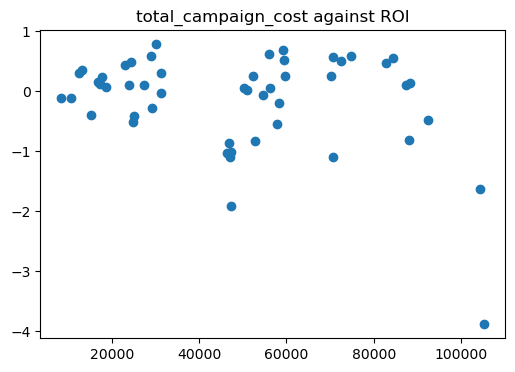

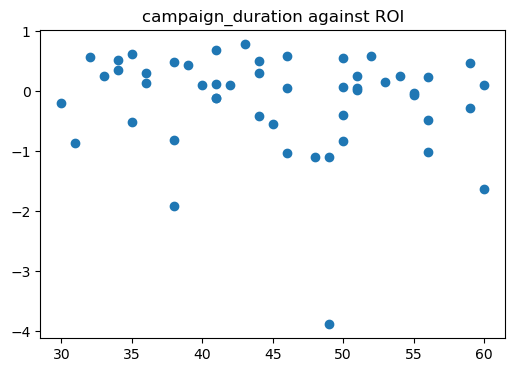

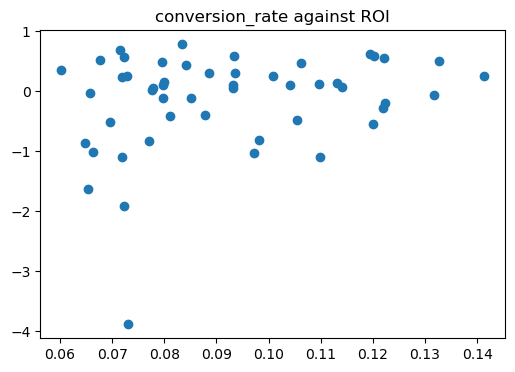

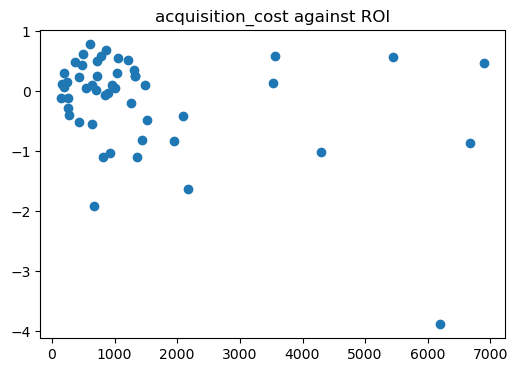

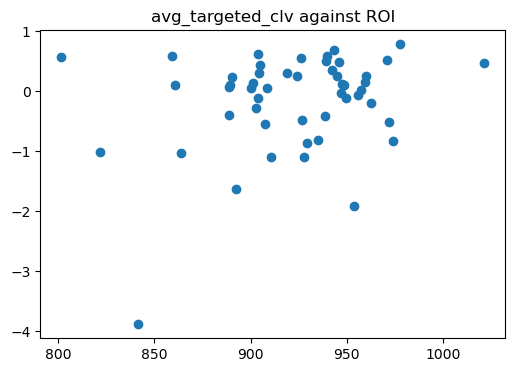

In [43]:
import matplotlib.pyplot as plt
import numpy as np
i = 1

y = roi_data['roi']
for feature in features:
    plt.figure(i, figsize=(6,4))
    plt.scatter(campaigns_encoded[feature],np.log(y))
    plt.title(feature + " against ROI")
    i += 1
    correlation = campaigns_encoded[feature].corr(y)
    correlation_log = campaigns_encoded[feature].corr(np.log(y))
    print(f"Correlation: {correlation:.2f}")
    print(f"Correlation with log(y): {correlation_log:.2f}")

plt.show()

In [44]:
# from sklearn.preprocessing import StandardScaler

# # Scale features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(campaigns_encoded)

# # Elbow method to find optimal clusters
# inertia = []
# for k in range(1, 10):
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
#     inertia.append(kmeans.inertia_)

# plt.plot(range(1, 10), inertia, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.show()

In [45]:
# # Visualise Clusters vs ROI
# import seaborn as sns
# from sklearn.cluster import KMeans


# df = pd.concat([campaigns_encoded,roi_data["roi"]], axis = 1)
# # Apply best K (e.g., 3 clusters)
# kmeans = KMeans(n_clusters=3).fit(X_scaled)
# df['cluster'] = kmeans.labels_

# # Compare ROI distributions per cluster
# sns.boxplot(data=df, x='cluster', y='roi')
# plt.title('ROI Distribution Across Clusters')
# plt.show()

In [46]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, r2_score
# from sklearn.preprocessing import StandardScaler

# # 1. Prepare Data
# # Assuming:
# X = campaigns_encoded[selected_features]
# y = roi_data["roi"]

# # Handle zeros/negatives in ROI if needed
# y = np.where(y <= 0, 1e-6, y)  # Replace zeros/negs with small positive

# # 2. Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # 3. Feature Scaling (optional but recommended for feature importance)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 4. Initialize and Train Model
# gb_model = GradientBoostingRegressor(
#     n_estimators=200,
#     learning_rate=0.05,
#     max_depth=4,
#     min_samples_leaf=5,
#     random_state=42
# )
# gb_model.fit(X_train_scaled, np.log1p(y_train))  # Log-transform target

# # 5. Predict and Inverse Transform
# y_pred = np.expm1(gb_model.predict(X_test_scaled))  # Convert back to original scale

# # 6. Evaluate
# print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
# print(f"R²: {r2_score(y_test, y_pred):.2f}")

Plotting histogram of "roi"

<Axes: xlabel='roi', ylabel='Count'>

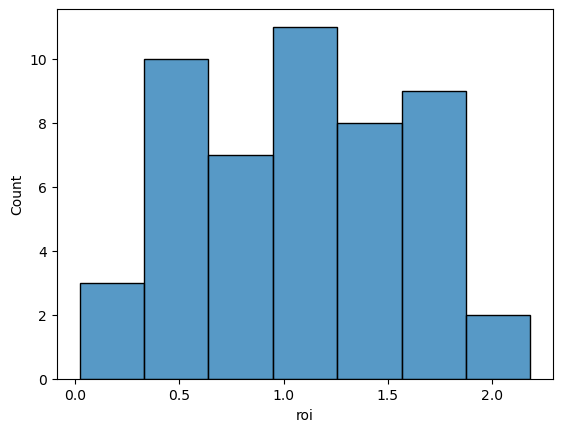

In [47]:
import seaborn as sns
sns.histplot(y)

## Change of model type
After consideration, a Gradient Boosting Classifier may be more optimal in answering the business question.

In [48]:
# features = ["total_campaign_cost", "campaign_duration",
#        'conversion_rate', 'acquisition_cost', "avg_targeted_clv"]
# customer_segments = ['customer_segment_High-Value',
#        'customer_segment_Middle-Market', 'customer_segment_Retired',
#        'customer_segment_Young Professionals']
# products = ['product_Credit Card', 'product_Investment Product', 'product_Mortgage',
#        'product_Personal Loan', 'product_Savings Account',
#        'product_Wealth Management']
# campaign_types = ['campaign_type_Email',
#        'campaign_type_Mobile App Notifications', 'campaign_type_SMS']

# selected_features = features + customer_segments + products + campaign_types

In [49]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import pandas as pd

# # Step 1: Define Categories for ROI
# bins = [0, 0.67, 1.33, float('inf')] # Define ROI thresholds
# labels = ['Low', 'Medium', 'High']  # Define ROI categories
# campaigns_encoded['roi_category'] = pd.cut(roi_data["roi"], bins=bins, labels=labels)

# # Step 2: Select Features and New Target Variable
# X = campaigns_encoded[selected_features]  # Use your existing features
# y = campaigns_encoded['roi_category']  # Use the new categorical target

# # Step 3: Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Step 4: Initialize Gradient Boosting Classifier
# model = GradientBoostingClassifier(random_state=1)

# # Step 5: Train the Model
# model.fit(X_train, y_train)

# # Step 6: Predict on Test Data
# y_pred = model.predict(X_test)

# # Step 7: Evaluate the Model
# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Classification Report
# print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=labels))

# # Confusion Matrix
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

## Model Evaluation
Some features may be providing additional noise. We measure feature importance to remove unhelpful features.

In [50]:
# feature_importances = pd.Series(model.feature_importances_, index=selected_features)
# print(feature_importances.sort_values(ascending=False))

Excluding unnecessary features:

In [51]:
# selected_features = feature_importances[feature_importances > 0.01].index.tolist()
# selected_features

In [52]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import pandas as pd
# from imblearn.over_sampling import SMOTE

# # Step 1: Define Categories for ROI
# bins = [0, 0.67, 1.33, float('inf')] # Define ROI thresholds
# labels = ['Low', 'Medium', 'High']  # Define ROI categories
# campaigns_encoded['roi_category'] = pd.cut(roi_data["roi"], bins=bins, labels=labels)

# # Step 2: Select Features and New Target Variable
# X = campaigns_encoded[selected_features]  # Use your existing features
# y = campaigns_encoded['roi_category']  # Use the new categorical target

# # Step 3: Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# # Step 4: Applying SMOTE to training data
# smote = SMOTE(random_state=3)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # Printing class distribution before/after SMOTE
# print("Original class distribution:", y_train.value_counts())
# print("Resampled class distribution:", pd.Series(y_train_res).value_counts())

# # Step 4: Initialize Gradient Boosting Classifier
# model = GradientBoostingClassifier(
#     random_state=1,
#     max_depth=3,
#     n_estimators=100,
#     subsample=0.7,
#     min_samples_leaf=5  # Prevent overfitting
# )

# # Step 5: Train the Model
# model.fit(X_train_res, y_train_res)

# # Step 6: Predict on Test Data
# y_pred = model.predict(X_test)

# # Step 7: Evaluate the Model
# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Classification Report
# print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=labels))

# # Confusion Matrix
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

In [53]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from imblearn.pipeline import make_pipeline  # Required for SMOTE in pipeline

# # 1. Define your pipeline with SMOTE first
# pipeline = make_pipeline(
#     SMOTE(random_state=3),
#     GradientBoostingClassifier(random_state=1)
# )

# # 2. Define parameter grid
# param_grid = {
#     'gradientboostingclassifier__max_depth': [2, 3, 4],
#     'gradientboostingclassifier__n_estimators': [50, 100, 150],
#     'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
#     'gradientboostingclassifier__min_samples_leaf': [3, 5, 7],
#     'smote__k_neighbors': [2, 3, 5]  # Tune SMOTE parameters too
# }

# # 3. Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring='balanced_accuracy',  # Better for imbalanced data
#     cv=5,                        # 5-fold CV
#     n_jobs=-1,                   # Use all CPU cores
#     verbose=1
# )

# # 4. Fit on training data (SMOTE happens inside CV loop)
# grid_search.fit(X_train, y_train)

# # 5. Get best model and evaluate
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# print("Best Parameters:", grid_search.best_params_)
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=labels))

In [54]:
# # Check if Medium ROI has indistinguishable feature values
# medium_data = X[y == 'Medium']
# print("Medium vs Others - Feature Medians:")
# print(pd.concat([
#     medium_data.median().rename('Medium'),
#     X[y != 'Medium'].median().rename('Other')
# ], axis=1))


In [55]:
features = ["total_campaign_cost", "campaign_duration",
       'conversion_rate', 'acquisition_cost']
customer_segments = ['customer_segment_High-Value',
       'customer_segment_Middle-Market', 'customer_segment_Retired',
       'customer_segment_Young Professionals']
products = ['product_Credit Card', 'product_Investment Product', 'product_Mortgage',
       'product_Personal Loan', 'product_Savings Account',
       'product_Wealth Management']
campaign_types = ['campaign_type_Email',
       'campaign_type_Mobile App Notifications', 'campaign_type_SMS']

selected_features = features + customer_segments + products + campaign_types

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Step 1: Define Categories for ROI
bins = [0, 0.67, 1.33, float('inf')] # Define ROI thresholds
labels = ['Low', 'Medium', 'High']  # Define ROI categories
campaigns_encoded['roi_category'] = pd.cut(roi_data["roi"], bins=bins, labels=labels)

# Step 2: Select Features and New Target Variable
X = campaigns_encoded[selected_features]  # Use your existing features
y = campaigns_encoded['roi_category']  # Use the new categorical target

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Step 4: Initialize Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=1)

# Step 5: Train the Model
model.fit(X_train, y_train)

# Step 6: Predict on Test Data
y_pred = model.predict(X_test)

# Step 7: Evaluate the Model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.2
Classification Report:
              precision    recall  f1-score   support

         Low       0.25      0.25      0.25         4
      Medium       0.00      0.00      0.00         1
        High       0.33      0.20      0.25         5

    accuracy                           0.20        10
   macro avg       0.19      0.15      0.17        10
weighted avg       0.27      0.20      0.23        10

Confusion Matrix:
[[1 1 2]
 [1 0 0]
 [2 2 1]]


In [57]:
feature_importances = pd.Series(model.feature_importances_, index=selected_features)
print(feature_importances.sort_values(ascending=False))

acquisition_cost                          0.255319
total_campaign_cost                       0.243211
conversion_rate                           0.137787
campaign_duration                         0.125135
customer_segment_Young Professionals      0.064142
product_Personal Loan                     0.037010
campaign_type_Mobile App Notifications    0.032036
campaign_type_SMS                         0.031186
campaign_type_Email                       0.027827
product_Credit Card                       0.017267
customer_segment_Retired                  0.013637
product_Wealth Management                 0.009737
customer_segment_High-Value               0.004589
customer_segment_Middle-Market            0.000661
product_Savings Account                   0.000253
product_Mortgage                          0.000136
product_Investment Product                0.000066
dtype: float64


In [58]:
selected_features = feature_importances[feature_importances > 0.01].index.tolist()
selected_features

['total_campaign_cost',
 'campaign_duration',
 'conversion_rate',
 'acquisition_cost',
 'customer_segment_Retired',
 'customer_segment_Young Professionals',
 'product_Credit Card',
 'product_Personal Loan',
 'campaign_type_Email',
 'campaign_type_Mobile App Notifications',
 'campaign_type_SMS']

In [59]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import pandas as pd
# from imblearn.over_sampling import SMOTE

# # Step 1: Define Categories for ROI
# bins = [0, 0.6, 1.4, float('inf')] # Define ROI thresholds
# labels = ['Low', 'Medium', 'High']  # Define ROI categories
# campaigns_encoded['roi_category'] = pd.cut(roi_data["roi"], bins=bins, labels=labels)

# # Step 2: Select Features and New Target Variable
# X = campaigns_encoded[selected_features]  # Use your existing features
# y = campaigns_encoded['roi_category']  # Use the new categorical target

# # Step 3: Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# # Step 4: Applying SMOTE to training data
# smote = SMOTE(random_state=3)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # Printing class distribution before/after SMOTE
# print("Original class distribution:", y_train.value_counts())
# print("Resampled class distribution:", pd.Series(y_train_res).value_counts())

# # Step 4: Initialize Gradient Boosting Classifier
# model = GradientBoostingClassifier(
#     random_state=1,
#     max_depth=3,
#     n_estimators=100,
#     subsample=0.7,
#     min_samples_leaf=5  # Prevent overfitting
# )

# # Step 5: Train the Model
# model.fit(X_train_res, y_train_res)

# # Step 6: Predict on Test Data
# y_pred = model.predict(X_test)

# # Step 7: Evaluate the Model
# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Classification Report
# print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=labels))

# # Confusion Matrix
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline  # Required for SMOTE in pipeline

bins = [0, 0.67, 1.33, float('inf')] # Define ROI thresholds
labels = ['Low', 'Medium', 'High']  # Define ROI categories
campaigns_encoded['roi_category'] = pd.cut(roi_data["roi"], bins=bins, labels=labels)

# Step 2: Select Features and New Target Variable
X = campaigns_encoded[selected_features]  # Use your existing features
y = campaigns_encoded['roi_category']  # Use the new categorical target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 1. Define your pipeline with SMOTE first
pipeline = make_pipeline(
    SMOTE(random_state=3),
    GradientBoostingClassifier(random_state=1)
)

# 2. Define parameter grid
param_grid = {
    'gradientboostingclassifier__max_depth': [2, 3, 4],
    'gradientboostingclassifier__n_estimators': [50, 100, 150],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__min_samples_leaf': [3, 5, 7],
    'smote__k_neighbors': [2, 3, 5]  # Tune SMOTE parameters too
}

# 3. Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='balanced_accuracy',  # Better for imbalanced data
    cv=5,                        # 5-fold CV
    n_jobs=-1,                   # Use all CPU cores
    verbose=1
)

# 4. Fit on training data (SMOTE happens inside CV loop)
grid_search.fit(X_train, y_train)

# 5. Get best model and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__min_samples_leaf': 5, 'gradientboostingclassifier__n_estimators': 50, 'smote__k_neighbors': 2}

Classification Report:
              precision    recall  f1-score   support

         Low       0.33      0.50      0.40         2
      Medium       0.50      0.33      0.40         3
        High       1.00      1.00      1.00         5

    accuracy                           0.70        10
   macro avg       0.61      0.61      0.60        10
weighted avg       0.72      0.70      0.70        10



C:\Users\rusya\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
